In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
# read in ground_truth_kds.txt as np array
ground_truth = np.loadtxt('../data/experimental_conditions/prot0.1/single_kds.txt')
print(ground_truth.shape)

(300,)


In [117]:
# read in result csv as pandas dataframe from first rounds
df = pd.read_csv('../data/experimental_conditions/prot0.1/results/PositionWiseKdEstimates.csv', sep='\t')
print(df.shape)
print(df.columns)

(100, 31)
Index(['pos1', 'wt base', 'max effect mut', 'median mut A', 'p-values mut A',
       '#resamplings mut A', '#lower estimates mut A',
       '#upper estimates mut A', '5. percentil mut A', '95. percentil mut A',
       'median mut C', 'p-values mut C', '#resamplings mut C',
       '#lower estimates mut C', '#upper estimates mut C',
       '5. percentil mut C', '95. percentil mut C', 'median mut G',
       'p-values mut G', '#resamplings mut G', '#lower estimates mut G',
       '#upper estimates mut G', '5. percentil mut G', '95. percentil mut G',
       'median mut U', 'p-values mut U', '#resamplings mut U',
       '#lower estimates mut U', '#upper estimates mut U',
       '5. percentil mut U', '95. percentil mut U'],
      dtype='object')


In [118]:
# get inferred median Kds
median_mut_C = df['median mut C'].values
median_mut_G = df['median mut G'].values
median_mut_U = df['median mut U'].values

print(median_mut_C.shape)
print(median_mut_G.shape)
print(median_mut_U.shape)

(100,)
(100,)
(100,)


In [119]:
# stack into one 1d array where the first 3 values are the first values of each array
# and so on
median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T.flatten()
print(median_Kds.shape)
print(median_Kds[:3])
print(median_mut_C[:1])
print(median_mut_G[:1])
print(median_mut_U[:1])

(300,)
[0.99202469 1.00056828 2.04980714]
[0.99202469]
[1.00056828]
[2.04980714]


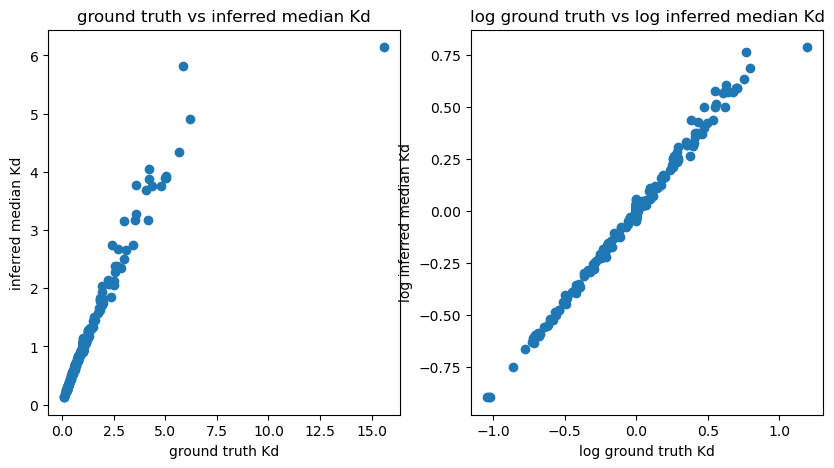

In [120]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot ground truth vs inferred median Kds
ax1.scatter(ground_truth, median_Kds)
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('inferred median Kd')
ax1.set_title('ground truth vs inferred median Kd')

# plot log ground truth vs log inferred median Kds
ax2.scatter(np.log10(ground_truth), np.log10(median_Kds))
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log inferred median Kd')
ax2.set_title('log ground truth vs log inferred median Kd')

plt.show()

In [121]:
def get_inferred_Kds(path : str):
    """
    Get inferred Kds from PositionWiseKdEstimates.csv file
    """
    df = pd.read_csv(path, sep='\t')
    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T.flatten()
    return median_Kds

In [122]:
prot_0_1 =  get_inferred_Kds('../data/experimental_conditions/prot0.1/results/PositionWiseKdEstimates.csv')
prot_1 = get_inferred_Kds('../data/experimental_conditions/prot1/results/PositionWiseKdEstimates.csv')
prot_10 = get_inferred_Kds('../data/experimental_conditions/prot10/results/PositionWiseKdEstimates.csv')

print(prot_0_1.shape)
print(prot_1.shape)
print(prot_10.shape)

(300,)
(300,)
(300,)


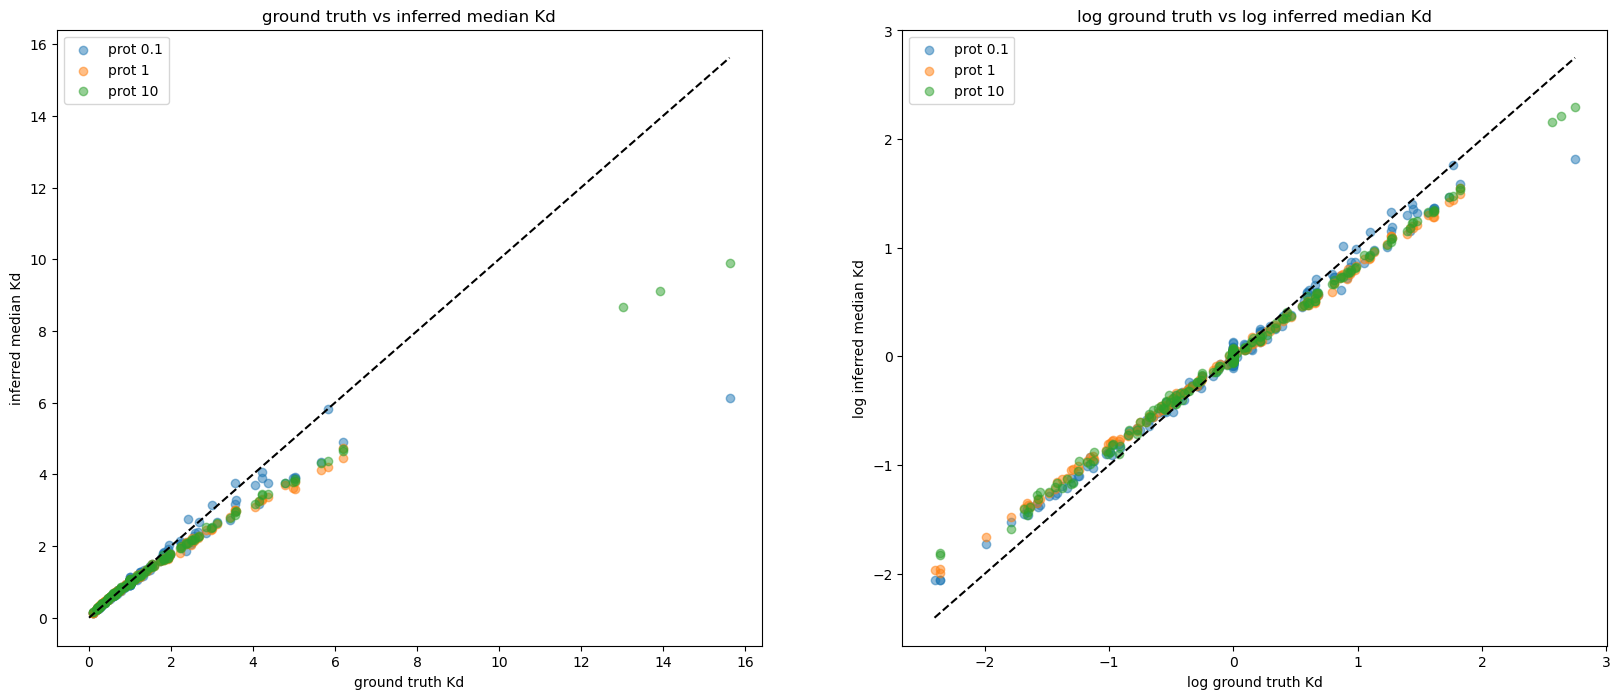

In [123]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot ground truth vs inferred median Kds of each protein concentration
ax1.scatter(ground_truth, prot_0_1, label='prot 0.1', alpha=0.5)
ax1.scatter(ground_truth, prot_1, label='prot 1', alpha=0.5)
ax1.scatter(ground_truth, prot_10, label='prot 10', alpha=0.5)
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('inferred median Kd')
ax1.set_title('ground truth vs inferred median Kd')
ax1.legend()
x = np.linspace(0, np.max(ground_truth), 100)
y = x
ax1.plot(x, y, color='black', linestyle='--')

# plot log ground truth vs log inferred median Kds of each protein concentration
ax2.scatter(np.log(ground_truth), np.log(prot_0_1), label='prot 0.1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_1), label='prot 1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_10), label='prot 10', alpha=0.5)
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log inferred median Kd')
ax2.set_title('log ground truth vs log inferred median Kd')
ax2.legend()
x = np.linspace(np.min(np.log(ground_truth)), np.max(np.log(ground_truth)), 100)
y = x
ax2.plot(x, y, color='black', linestyle='--')

plt.show()

In [124]:
# do the same for the second round with prot 0.1
prot_01_01 = get_inferred_Kds('../data/experimental_conditions/secondFromProt0.1/prot0.1/results/PositionWiseKdEstimates.csv')
prot_01_1 = get_inferred_Kds('../data/experimental_conditions/secondFromProt0.1/prot1/results/PositionWiseKdEstimates.csv')
prot_01_10 = get_inferred_Kds('../data/experimental_conditions/secondFromProt0.1/prot10/results/PositionWiseKdEstimates.csv')

print(prot_01_01.shape)
print(prot_01_1.shape)
print(prot_01_10.shape)

(300,)
(300,)
(300,)


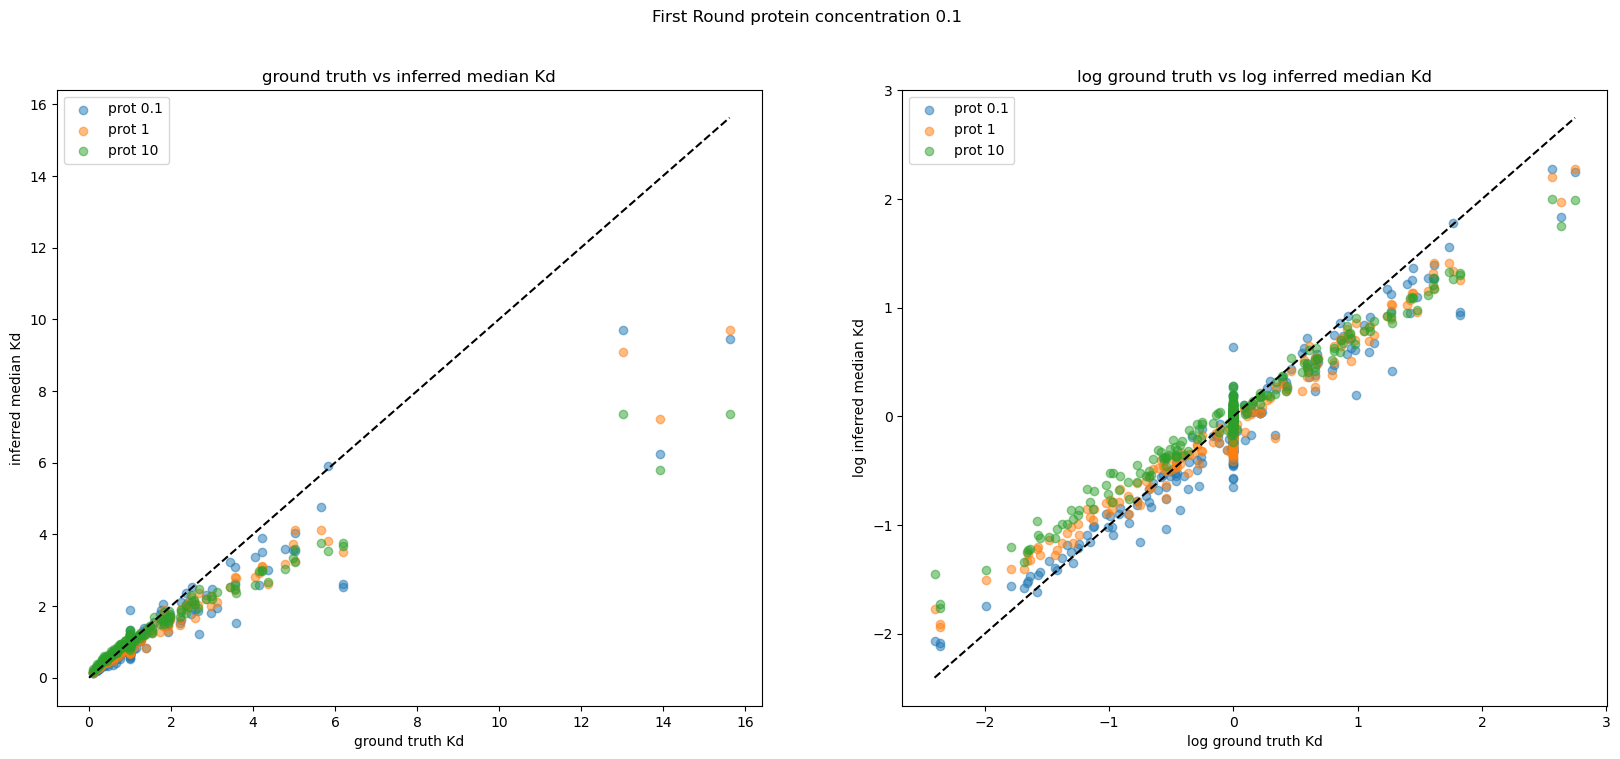

In [126]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot ground truth vs inferred median Kds of each protein concentration
ax1.scatter(ground_truth, prot_01_01, label='prot 0.1', alpha=0.5)
ax1.scatter(ground_truth, prot_01_1, label='prot 1', alpha=0.5)
ax1.scatter(ground_truth, prot_01_10, label='prot 10', alpha=0.5)
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('inferred median Kd')
ax1.set_title('ground truth vs inferred median Kd')
ax1.legend()
x = np.linspace(0, np.max(ground_truth), 100)
y = x
ax1.plot(x, y, color='black', linestyle='--')

# plot log ground truth vs log inferred median Kds of each protein concentration
ax2.scatter(np.log(ground_truth), np.log(prot_01_01), label='prot 0.1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_01_1), label='prot 1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_01_10), label='prot 10', alpha=0.5)
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log inferred median Kd')
ax2.set_title('log ground truth vs log inferred median Kd')
ax2.legend()
x = np.linspace(np.min(np.log(ground_truth)), np.max(np.log(ground_truth)), 100)
y = x
ax2.plot(x, y, color='black', linestyle='--')

# set overall title
plt.suptitle('First Round protein concentration 0.1')

plt.show()

In [127]:
# do the same for the second round with prot 1
prot_1_01 = get_inferred_Kds('../data/experimental_conditions/secondFromProt1/prot0.1/results/PositionWiseKdEstimates.csv')
prot_1_1 = get_inferred_Kds('../data/experimental_conditions/secondFromProt1/prot1/results/PositionWiseKdEstimates.csv')
prot_1_10 = get_inferred_Kds('../data/experimental_conditions/secondFromProt1/prot10/results/PositionWiseKdEstimates.csv')

print(prot_1_01.shape)
print(prot_1_1.shape)
print(prot_1_10.shape)

(300,)
(300,)
(300,)


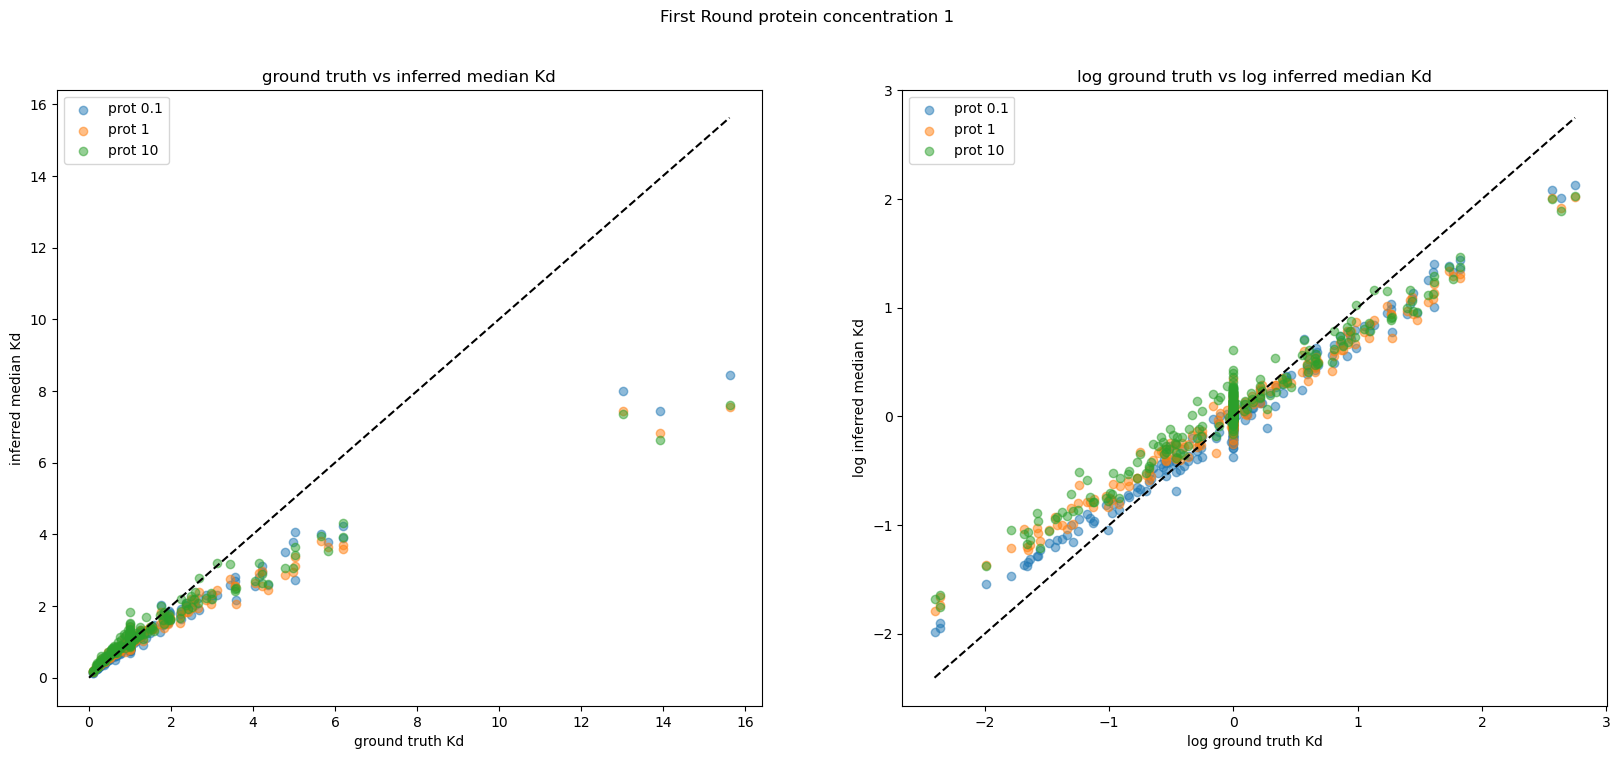

In [128]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot ground truth vs inferred median Kds of each protein concentration
ax1.scatter(ground_truth, prot_1_01, label='prot 0.1', alpha=0.5)
ax1.scatter(ground_truth, prot_1_1, label='prot 1', alpha=0.5)
ax1.scatter(ground_truth, prot_1_10, label='prot 10', alpha=0.5)
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('inferred median Kd')
ax1.set_title('ground truth vs inferred median Kd')
ax1.legend()
x = np.linspace(0, np.max(ground_truth), 100)
y = x
ax1.plot(x, y, color='black', linestyle='--')

# plot log ground truth vs log inferred median Kds of each protein concentration
ax2.scatter(np.log(ground_truth), np.log(prot_1_01), label='prot 0.1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_1_1), label='prot 1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_1_10), label='prot 10', alpha=0.5)
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log inferred median Kd')
ax2.set_title('log ground truth vs log inferred median Kd')
ax2.legend()
x = np.linspace(np.min(np.log(ground_truth)), np.max(np.log(ground_truth)), 100)
y = x
ax2.plot(x, y, color='black', linestyle='--')

# set overall title
plt.suptitle('First Round protein concentration 1')

plt.show()

In [129]:
# do the same for the second round with prot 10
prot_10_01 = get_inferred_Kds('../data/experimental_conditions/secondFromProt10/prot0.1/results/PositionWiseKdEstimates.csv')
prot_10_1 = get_inferred_Kds('../data/experimental_conditions/secondFromProt10/prot1/results/PositionWiseKdEstimates.csv')
prot_10_10 = get_inferred_Kds('../data/experimental_conditions/secondFromProt10/prot10/results/PositionWiseKdEstimates.csv')

print(prot_10_01.shape)
print(prot_10_1.shape)
print(prot_10_10.shape)

(300,)
(300,)
(300,)


In [132]:
def inference_plot(ground_truth_Kds : np.array, inferred_Kds_1 : np.array, inferred_Kds_2 : np.array, inferred_Kds_3 : np.array, title : str):
    """
    Plot ground truth vs inferred median Kds of each protein concentration
    """
    # set up 2 side by side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # plot ground truth vs inferred median Kds of each protein concentration
    ax1.scatter(ground_truth_Kds, inferred_Kds_1, label='prot 0.1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, inferred_Kds_2, label='prot 1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, inferred_Kds_3, label='prot 10', alpha=0.5)
    ax1.set_xlabel('ground truth Kd')
    ax1.set_ylabel('inferred median Kd')
    ax1.set_title('ground truth vs inferred median Kd')
    ax1.legend()
    x = np.linspace(0, np.max(ground_truth_Kds), 100)
    y = x
    ax1.plot(x, y, color='black', linestyle='--')

    # plot log ground truth vs log inferred median Kds of each protein concentration
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_1), label='prot 0.1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_2), label='prot 1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_3), label='prot 10', alpha=0.5)
    ax2.set_xlabel('log ground truth Kd')
    ax2.set_ylabel('log inferred median Kd')
    ax2.set_title('log ground truth vs log inferred median Kd')
    ax2.legend()
    x = np.linspace(np.min(np.log(ground_truth_Kds)), np.max(np.log(ground_truth_Kds)), 100)
    y = x
    ax2.plot(x, y, color='black', linestyle='--')

    # set overall title
    plt.suptitle(title)

    plt.show()

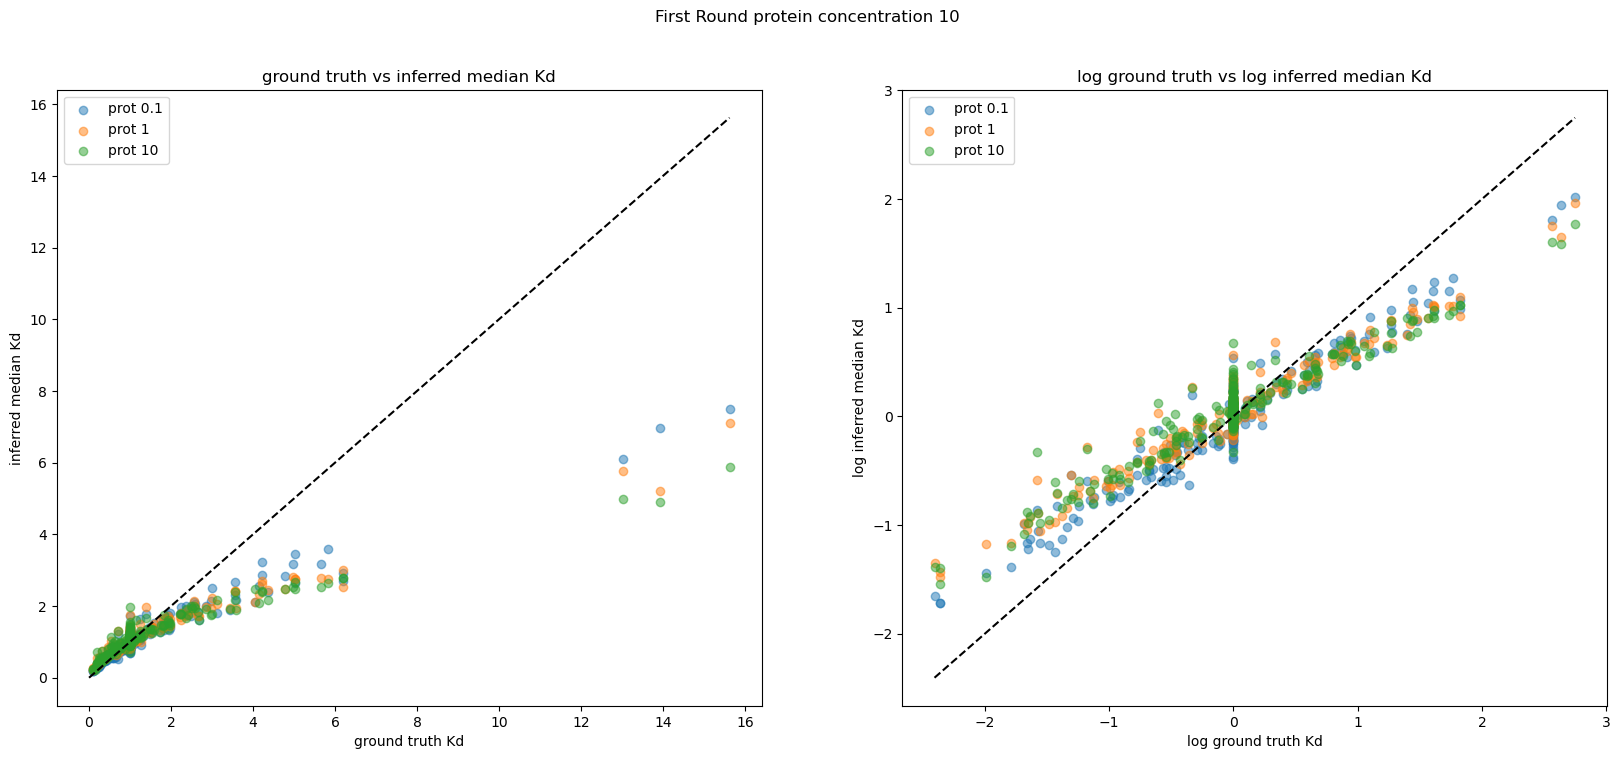

In [133]:
inference_plot(ground_truth, prot_10_01, prot_10_1, prot_10_10, 'First Round protein concentration 10')